In [250]:
using LinearAlgebra, FastGaussQuadrature, Plots
include("..\\Code_jail\\Misc.jl")
include("..\\Code_jail\\myquad.jl")

Hermite_quad (generic function with 1 method)

# Computing $\int_{-\infty}^{\infty}\exp(ikx-ω(k)t)g(k)\mathrm{d}k$, with $x\in\mathbb{R}^+$
## The integral
Say we have dispersion relation $ω(k)\in\mathbb{P}^n$ and a function $g(k)$ (restrictions on this?). Assume $x\in\mathbb{R}^+$, we then aim to compute
$$
\int_{-\infty}^{\infty}\exp(ikx-ω(k)t)g(k)\mathrm{d}k,
$$
for a small $t$ where $g(k)$ has poles only on the real line. To this end, we compute a different integral:
$$
\int_{-\infty}^{\infty}\exp(ikx-ω(k)t)g(k)\mathrm{d}k\overset{kt^{1/n}=z}{=}\int_{-\infty}^{\infty}\exp(izt^{-1/n}x-ω(zt^{-1/n})t)g(zt^{-1/n})t^{1/n}\mathrm{d}z.
$$
This such that $ω(zt^{-1/n})t → w_{n}z^n$ as $t → 0$. However, note that $t^{-1/n} → \infty$ as $t → 0$, so we hope that $\mathcal{R}e(izt^{-1/n}x)≤  0$. For notation, define $\Omega_+=\{z|\mathcal{R}e(w_{n}z^n)\geq0\}$ and $\Omega_-=\{z|\mathcal{R}e(w_{n}z^n)<0\}$. Assuming $n>1$, we do not need to worry about the first term, however big $t^{-1/n}$ is (this will be due to us using the steepest descent path).
## The deformation
 Now, why am I talking about the complex plane all of a suddon? Deformations, of course! To use steepest descent and avoid oscilatory behavior we deform to $\Gamma$. For this we deform through the upper half plane. The difficult part is the need for $\mathcal{R}e(w_{n}z^n)\geq0$. This necesity prohibits the integral itself to not even exist, namely if the starting and end point of the original path is in $Ω₋$. However, let's assume its integrable, then we want $\mathcal{R}e(w_{n}z^n)\geq0$ for $z$ in the UHP. Define $w_{n}=w_r+w_ii$ and $z_{n}=z_r+z_ii=re^{iθ}$, we then find where $\mathcal{R}e(w_{n}z^n)=0$:
$$
\mathcal{R}e((w_r+w_ii)e^{inθ})= w_r\cos(n\theta)-w_i\sin(n\theta) = 0 ⇒ θ_j = \frac{\arctan(w_r/w_i)+j\pi}{n},~~j\in\mathbb{Z},~ s.t.~~ θ_j \in [0, 2π).
$$
As for the amount of $θ_j$s, it depends on if $\Omega_+$ starts and where it ends in the upper half plane.  

For the deformation to happen, we aim to use Jordan's lemma. We make circle segments over that domain where $\Omega_+$. The integral over these will go to zero because of Jordan's lemma. Sadly, the UHP does not consist of only $\mathcal{R}e(w_{n}z^n)\geq0$. One could then deform to go back to zero, avoid $\Omega_-$ and then go back to infinity in $\Omega_+$. But the whole reason for deforming is so that we escape $z=0$. Therefore, we need to go through the $\Omega_-$. For this we use steepest descent. Once we have this deformation path, we can use that $g$ and the exponential are analytic in the UHP so get the integral we hope to get, through decomposing the full path into that over the real line and $\Gamma$. 

First we try to find the path through which we will go to and come back from infinity over the good regions $\Omega_+$. The main idea is that we aim to maximize $\mathcal{R}e(w_{n}z^n)$ in every region. This is easy to find:
$$
f(z) = \mathcal{R}e(w_{n}z^n) ⇒ f'(z) = \mathcal{R}e(nw_{n}z^{n-1}) = nr\left(w_r\cos((n-1)\theta)-w_i\sin((n-1)\theta)\right) = 0⇒ θ_j = \frac{\arctan(w_r/w_i)+j\pi}{n-1},~~j\in\mathbb{Z},~ s.t.~~ θ_j \in [0, π].
$$
I don't know if this is very true, but graphically it's easy to see that the path at which $\mathcal{R}e(w_{n}z^n)$ is maximize is $r↦ r\exp((θ_j+θ_{j+1})/2)$, where they $θ_j$ and $θ_{j+1}$ are boundaries of $Ω_+$. This line, will describe how we go to and from infinity in $\Omega_+$.

Over $\Omega_-$, we will go through the critical points of $ikx-ω(kt^{-1/n})t$, which is easy to compute automaticaly though companion matrices. As for how we go through it, we take the shortest path through the critical point, which is perendicular to $r ↦ r\exp(i(θ_j+θ_{j+1})/2)$, where $θ_j$ and $θ_{j+1}$ are boundaries of $Ω_-$.

# Basic code and structures

In [251]:
function angle2pi(z)
    ang = angle.(z);
    if ang isa Array{<:Number,1}
        for i1 = 1:length(ang)
            if ang[i1] < 0
                ang[i1] += 2*π
            end
        end
    else
        ang = ang < 0 ? ang + 2π : ang 
    end
    return ang
end
function polar(z)
    ang = angle2pi(z);
    return z ≈ 0 ? (0, 0) : (abs.(z), ang)
end

mutable struct Input_sf
    w::Vector
    x::Number
    t::Number
    xθ::Number
    wr::Number
    wθ::Number
end

function Input_sf(ww::Vector,xx::Number,tt::Number)
    xxr, xxθ = polar(xx);
    wwr, wwθ = polar(w[end]);
    Input_sf(ww,xxr,tt,xxθ,wwr,wwθ)
end

function OrderRoots(xx)
    angles = angle2pi(xx)
    sorted_indices = sortperm(angles)
    return xx[sorted_indices]
end
ω(w) = (z) -> sum([w[i] .* z.^(i + 1) for i in 1:length(w)])
DDω(w) = (z) -> sum([(i + 1) * i .* w[i] .* z.^(i-1) for i in 1:length(w)])
#Correct
Φ(inp, k) = begin
    ww = inp.w; xx = inp.x; tt = inp.t;
    ω_kt = ω(ww)(k .* tt.^(-1 / (length(ww) + 1)))
    return 1im*k .- ω_kt .* tt ./ xx 
end
#Correct
P(inp, k) = begin
    xx = inp.x; 
    result = exp(xx * Φ(inp, k))
    result ≈ 0.0 ? 0 : result
end
function sortreal(xx)
    return sort(xx, by=real)
end

sortreal (generic function with 1 method)

In [252]:
function kk0(inp)
    ww = inp.w; xx = inp.x; tt = inp.t; xxθ = inp.xθ

    m = length(ww);
    a = zeros(m) .* 1im
    a[1] = 1im*xx/(-(m+1)*ww[m])
    for i1 = 1:(m-1)
        a[i1+1] = (i1+1)*ww[i1]*tt^((m-i1)/(m+1))/ ((m+1)*ww[m] )
    end
    A = zeros(m,m) * 1im;
    for i1=1:m-1
        A[i1+1,i1] = 1.0;
    end
    A[:,m] = -1. .* a
    E = A |> eigen
    result = (E.values) |> filter(k -> real(ww[end]*(k)^(m+1))<=0 || imag(k)>=-.01)
    return OrderRoots(result)
end

function GlobalR(inp)
    ww = inp.w; xx = inp.x;
    return (30 + abs(xx)^2 + 1000 / length(ww))^(1 / (length(ww) + 1))
end

function dom_sectioner(path)
    a = -1; b = 1;
    distances = [abs(path[i][2]-path[i][1]) for i in 1:length(path)]; distances .*= (b-a)/sum(distances)
    t_vals = zeros(length(path)+1); t_vals[1] = a; t_vals[end] = b;
    for i1 = 1:length(path)-1
        t_vals[i1+1] = t_vals[i1]+distances[i1]
    end
    return t_vals
end

function pwlinf_maker(t,t_vals,path_nodes,meth)
    for i1 = 1:(length(t_vals)-1)
        if (t_vals[i1] <= t && t <= t_vals[i1+1])
            return (t-t_vals[i1])/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + (t-t_vals[i1+1])/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
        end
    end
    if t_vals[end] <= t
        return (t-t_vals[end-1])/(t_vals[end]-t_vals[end-1])*path_nodes[end] + (t-t_vals[end])/(t_vals[end-1]-t_vals[end])*path_nodes[end-1]
    elseif t <= t_vals[1]
        return (t-t_vals[1])/(t_vals[2]-t_vals[1])*path_nodes[2] + (t-t_vals[2])/(t_vals[1]-t_vals[2])*path_nodes[1]
    end
end

function Dpwlinf_maker(t,t_vals,path_nodes,meth)
    for i1 = 1:(length(t_vals)-1)
        if t >= t_vals[i1] && t <= t_vals[i1+1]
            return 1/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + 1/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
        end
    end
    if t_vals[end] <= t
        return 1/(t_vals[end]-t_vals[end-1])*path_nodes[end] + 1/(t_vals[end-1]-t_vals[end])*path_nodes[end-1]
    elseif t <= t_vals[1]
        return 1/(t_vals[2]-t_vals[1])*path_nodes[2] + 1/(t_vals[1]-t_vals[2])*path_nodes[1]
    end
end

function fpath_maker(path,cate)
    t_vals = dom_sectioner(path)
    meth = [];
    tt = [];
    funcs = [];
    Dfuncs = [];
    for i1 = 1:length(path)
        push!(meth, "Legendre")
        xgrid = path[i1];

        push!(funcs, t -> pwlinf_maker(t,t_vals[i1:(i1+1)],path[i1],meth[i1]))
        push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[i1:(i1+1)],path[i1],meth[i1]))
        #push!(tt, [t_vals[ind_sec_tmp[i1][1]],t_vals[ind_sec_tmp[i1][2]]])
        push!(tt, t_vals[i1:(i1+1)])
    end
    return funcs, Dfuncs, tt, meth
end

struct Deformation
    pp::Vector
    cc::Vector
    path::Vector
    Dpath::Vector
    tt::Vector
    meth::Vector
    w::Vector
    x::Number
end

function Deformation(path::Vector,cate::Vector,w::Vector,x::Number)
    func, Dfunc, tt, meth = fpath_maker(path,cate)
    Deformation(path,cate,func, Dfunc, tt, meth,w,x)
end

function DomainPlot(D::Deformation)
    pl = plot();
    path = D.pp;
    cate = D.cc
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 in 1:length(path)
        plot!([real(path[i1][1]),real(path[i1][2])],[imag(path[i1][1]),imag(path[i1][2])], arrow=true, color =:black, linewidth =2, label ="");
        for i2 in 1:2
            if cate[i1][i2] == "CP"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif cate[i1][i2] == "inf"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif cate[i1][i2] == "CP_ext"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif cate[i1][i2] == "CP_ent"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end

    ww = D.w;
    n = length(ww) + 1;

    xr = xlims(pl);
    yr = ylims(pl);

    # Generate a grid of complex numbers
    xplt = LinRange(minimum([xr[1],yr[1]]), maximum([xr[2],yr[2]]), 500)
    yplt = LinRange(minimum([xr[1],yr[1]]), maximum([xr[2],yr[2]]), 500)
    z = [a + 1im*b for b in yplt, a in xplt]
    
    # Create a mask for points where real((x + yi)^2) < 0
    #mask = [real(-1im*ω(ww)(zi)) >= 0 for zi in z]
    mask = [real(ww[end]*(zi)^n) < 0 for zi in z]

    mmask = [ NaN for zi in z]
    mmask[mask] .= 0
    heatmap!(xplt, yplt, mmask, c=:RdBu,  alpha =0.5, cbar=false,aspect_ratio=:equal, xlims = (minimum([xr[1],yr[1]]), maximum([xr[2],yr[2]])), ylims = (minimum([xr[1],yr[1]]), maximum([xr[2],yr[2]])))

    pl = plot!()
end

function NumericalDomainPlot(D::Deformation)
    Legendre_label = "Legendre";
    Clen_Curt_label = "Clenshaw-Curtis";
    plot()
    for i1 = 1:length(D.path)
        t = range(D.tt[i1][1],D.tt[i1][end],100)
        if D.meth[i1] == "Clenshaw-Curtis"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:purple3, linewidth =2, label = Clen_Curt_label, aspect_ratio=:equal)


            Clen_Curt_label = "";
        elseif D.meth[i1] == "Legendre"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:magenta4, linewidth =2, label = Legendre_label, aspect_ratio=:equal)

            x, w = gausslegendre(15);
            
            trans_func = x -> (D.tt[i1][end] + D.tt[i1][1])/2 + x * (D.tt[i1][end] - D.tt[i1][1])/2 ;
            scatter!(real.(D.path[i1].(trans_func.(x))),imag.(D.path[i1].(trans_func.(x))), color =:magenta4, linewidth =2, label = "")
            Legendre_label = "";
        end
    end
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 = 1:length(D.cc)
        for i2 in 1:2
            if D.cc[i1][i2] == "CP"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif D.cc[i1][i2] == "inf"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif D.cc[i1][i2] == "CP_ext"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif D.cc[i1][i2] == "CP_ent"
                scatter!([real(D.pp[i1][i2])],[imag(D.pp[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end
    
    plot!()|>display
end

function My_Integrate(int_f,Defor,N)
    res = 0im;
    for i1 = 1:length(Defor.tt)
        s = curv(Defor.path[i1],Defor.tt[i1][1],Defor.tt[i1][end],Defor.Dpath[i1],N)
        if Defor.meth[i1] == "Legendre"
            f = stand_int(int_f,s)
            x, w = gausslegendre(N);
            res += dot(w,f.(x))
           
        elseif Defor.meth[i1] == "Clenshaw-Curtis"
            res += Clen_Curt(int_f,s)
        
        end
    end
    return res
end

function edgeθ_finder(w)
    n = length(w)+1
    wend = w[end];
    A = real(wend); B = imag(wend);
    θ = atan(A/B)/n
    θs = [θ]
    i1 = 1
    while 0 <= θ - i1*π/n
        push!(θs,θ - i1*π/n)
        i1 += 1
    end
    i1 = 1
    while θ + i1*π/n < 2*π
        append!(θs,θ + i1*π/n)
        i1 += 1
    end
    return [θs[end-1]-2*π;θs[end]-2*π;θs;θs[1]+2*π;θs[2]+2*π]
end

function SmallXPath(inp)
    w = inp.w; x = inp.x; t = inp.t;
    edgeθs = edgeθ_finder(w)

    if length(w[end]) != 2
        edgeθs = edgeθs[2:(length(edgeθs))];
    end
    
    if real(w[end]) ≈ 0
        n = real(w[end]*(exp(1im*(π-0.001)*(length(w)+1)))) < 0 ? Int(ceil((length(edgeθs)-2)/4 + 1)) : Int(floor((length(edgeθs)-2)/4 + 1))
    end
    
    if length(w[end]) != 2
        n =  Int(ceil((length(edgeθs)-2)/4 + 1))
    end
    
    SmallR = .5; 
    BigR = GlobalR(inp)
    θs = zeros(n);
    
    rotation = exp(-1im*angle(w[end])/2)
    s = [];
    c = [];
    if length(w) == 1
        CP = 1im;
        R, θ = polar(CP)

        CPent = CP - sqrt(2)*abs(CP)*rotation
        CPext = CP + sqrt(2)*abs(CP)*rotation

        entinf = CPent - GlobalR(inp)*rotation
        extinf = CPext + GlobalR(inp)*rotation
        
        push!(s,[entinf, CPent], [CPent,CP], [CP,CPext], [CPext, extinf])
        push!(c, ["inf","CP_ent"],["CP_ent","CP"], ["CP","CP_ext"], ["CP_ext", "inf"])
        return s,c
    end
    for i1 = 1:n
        θs[i1] = (edgeθs[2*(i1)-1] +  edgeθs[2*i1])/2
    end
    if real(w[end]) ≈ 0
        θs = real(w[end]*exp(1im*0.001*(length(w)+1)))<0 ? θs : (θs[1:(length(θs)-1)] + θs[2:length(θs)])/2
    end
    p1 = SmallR * exp.(1im*θs)
    p2 = BigR * exp.(1im*θs)
    
    for i in 1:length(p1) - 1
        push!(s, [p2[i+1], p1[i+1]], [p1[i+1], p1[i]], [p1[i], p2[i]])
        push!(c, ["inf", "CP_ent"], ["CP_ent", "CP_ext"], ["CP_ext", "inf"])
    end
    return s, c
end


function FullPath(inp)
    w = inp.w; x = inp.x; t = inp.t; xθ = inp.xθ; wθ = inp.wθ
    if abs(x) < 0.1-eps() || isempty(kk0(inp))
        path, cate = SmallXPath(inp)
        return Deformation(path, cate,w,x)
    end

    n = length(w) + 1

    rotation = exp(-1im*angle2pi(wθ)/n)
    edgeθs = edgeθ_finder(w)
    K0 = kk0(inp)

    connect = []
    category = []
    if n == 2
        CP = K0[1];
        R, θ = polar(CP)

        CPent = CP - sqrt(2)*abs(CP)*rotation
        CPext = CP + sqrt(2)*abs(CP)*rotation

        #entinf = CPent + GlobalR(inp)*exp(3im/4*π)*rotation
        #extinf = CPext + GlobalR(inp)*exp(1im/4*π)*rotation
        entinf = CPent - GlobalR(inp)*rotation
        extinf = CPext + GlobalR(inp)*rotation
        
        push!(connect,[entinf, CPent], [CPent,CP], [CP,CPext], [CPext, extinf])
        push!(category, ["inf","CP_ent"],["CP_ent","CP"], ["CP","CP_ext"], ["CP_ext", "inf"])
        return Deformation(connect,category,w,x)
    end
    i2 = 2;
    for i1 = 1:length(K0)
        CP = K0[i1];
        R, θ = polar(CP)
        while !(edgeθs[i2]< θ && θ < edgeθs[i2+1])
            if edgeθs[i2] == θ || θ == edgeθs[i2+1]
                if real(w[end]*(5*exp(1im*(edgeθs[i2]+edgeθs[i2+1])/2))^(n)) < 0
                    break
                end
            end
            i2 += 1
        end
        if i2 == 2
            i2 += 1
        elseif i2 == length(edgeθs)/2+1
            i2 -= 1
        end
        θent = (edgeθs[i2+1]+edgeθs[i2+2])/2
        θext = (edgeθs[i2-1]+edgeθs[i2])/2
        θmid = (edgeθs[i2]+edgeθs[i2+1])/2

        #Δθent = θent-θ;
        #Δθext = θ-θext;
        #CPent = R/cos(Δθent)*exp(1im*θent)
        #CPext = R/cos(Δθext)*exp(1im*θext)

        Δθent = θent-θmid;
        Δθext = θmid-θext;
        CPent = cos(θ-θmid)*R/cos(Δθent)*exp(1im*θent)
        CPext = cos(θ-θmid)*R/cos(Δθext)*exp(1im*θext)

        entinf = GlobalR(inp) * exp(1im*θent)
        extinf = GlobalR(inp) * exp(1im*θext)

        push!(connect,[entinf, CPent], [CPent,CP], [CP,CPext], [CPext, extinf])
        push!(category, ["inf","CP_ent"],["CP_ent","CP"], ["CP","CP_ext"], ["CP_ext", "inf"])
    end

    return Deformation(connect,category,w,x)
end

function Integrand(inp, g)
    w = inp.w;
    DD = FullPath(inp)
    n = length(w) + 1

    integrand = z -> g(z) * P(inp, z)
    return integrand, DD
end

function Residue(f,z)
    s = curv( t -> z .+ exp.(1im*t), 0, 2*π, t -> 1im*exp.(1im*t),100)
    Clen_Curt(f,s)/(2*π*1im)
end

function SpecialFunction(w::Vector, x::Number, t::Number, m::Number, N::Number,gg::Function)
    n = length(w) + 1
    if real(w[end]) < 0 || real((-1)^n*w[end]) < 0
        @warn "Deformation cannot be made: exponential growth over real line"
    end
    xθ = angle(x)
    w = [ w[j] * (exp(-1im*xθ))^(j + 1) for j in 1:length(w)];
    g = z -> gg(z * exp(-1im*xθ) * t^(-1/n))

    inp = Input_sf(w,x * t^(-1/n)+ eps(),t);

    integrand, DD = Integrand(inp, g);
    #DomainPlot(DD) |> display
    vals = My_Integrate(integrand, DD,N)

    vals -=  (real(x) < 0 && m < 0) ? 2 * π * 1im * Residue(z -> g(z) * P(inp, z), 0) : 0

    (t)^(-1/n) * exp(-1im*xθ) * vals
end

function SpecialFunction(w::Vector, xx::Number, tt::Number, m::Number, N::Number)
    g = z -> (1im*z).^m
    SpecialFunction(w, xx, tt, m, N,g)
end

SpecialFunction (generic function with 2 methods)

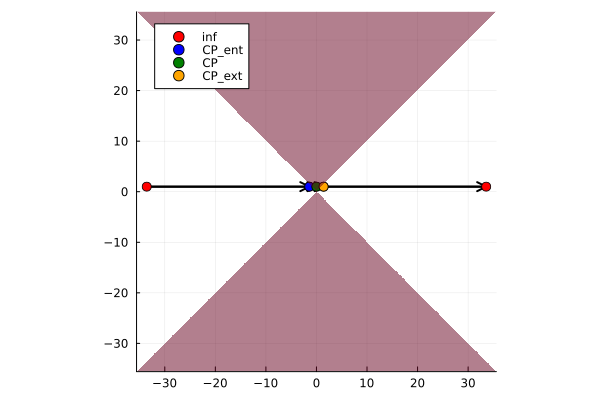

In [253]:
w = [1]
x = 2
t = 0.0001;
inp = Input_sf(w,x,t)
DD = FullPath(inp)
pl = DomainPlot(DD)|>display

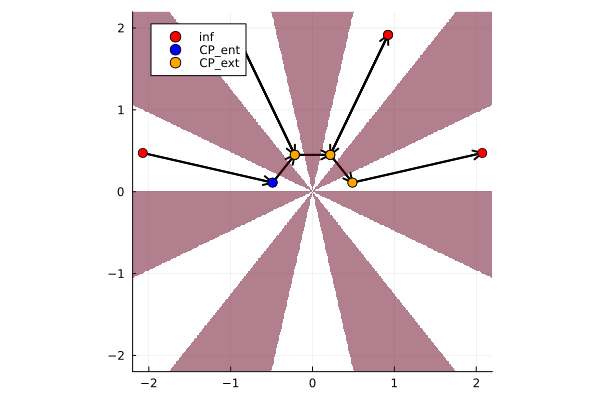

In [254]:
w = -[-2,-9,5,-1,-4,1im]
x = 0.01
t = 1;
inp = Input_sf(w,x,t)
DD = FullPath(inp)
pl = DomainPlot(DD)|>display

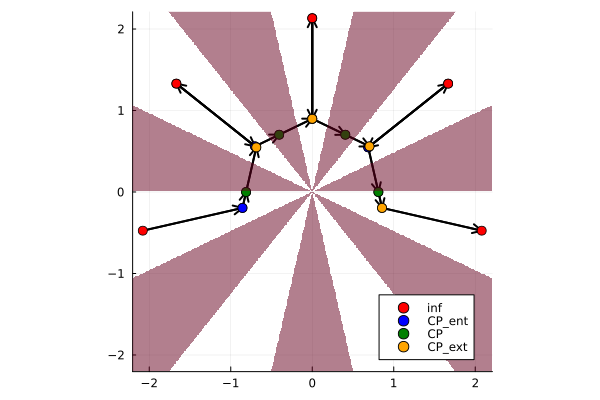

In [255]:
w = [0,0,0,0,0,1im]
x = 2
t = 0.0000001;
inp = Input_sf(w,x,t)
DD = FullPath(inp)
pl = DomainPlot(DD)|>display

# The current deformation only works for small t because of the t scaling

In [256]:
w = -[-2,-9,5,-1,-4,1,-3]
N = 200;
m = 1;
x = 2;
t = 0.00001;
funt = SpecialFunction(w, x, t, m, N)

1.3136276610325217 + 0.09396981502822047im

In [257]:
w = [1]
N = 200;
m = -1;
x = 1;
t = 1;
funt = SpecialFunction(w, x, t, m, N)

-1.5063940612579418 + 2.498001805406602e-16im

In [258]:
w = [0,exp(-3im*π/6)]
N = 200;
m = -1;
x = 2;
t = 0.0001;
funt = SpecialFunction(w, x, t, m, N)

┌ Warning: Deformation cannot be made: exponential growth over real line
└ @ Main In[252]:369


-7.24173471574065e-49 - 2.1416529641435233e-63im

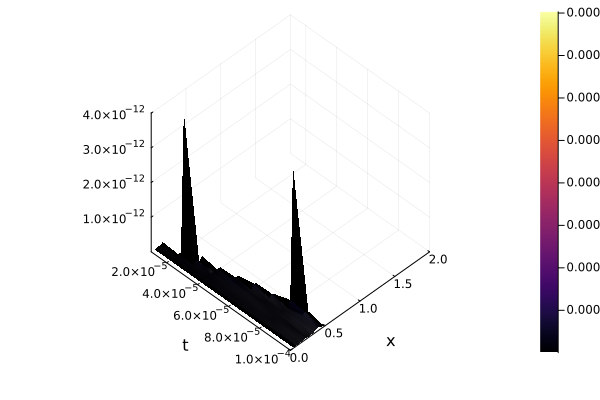

In [259]:
w = [1]
N = 200;
m = 1;

funt = (x,t) -> SpecialFunction(w, x, t, m, N);
Solu = (x,t) -> -exp(-x^2/(4*t))*sqrt(pi)*x/(2*t^(3/2));

L = 2
Nt = 10;
Nx = 101;
T = 0.0001
tt = T/(Nt):T/(Nt):T
xx = 0:2*L/(Nx-1):L

Qsol = Complex.(zeros(length(xx),length(tt)))
Rsol = Complex.(zeros(length(xx),length(tt)))
for i2 = 1:Nt
    Qsol[:,i2] = map(x->funt(x,tt[i2]),xx)
    Rsol[:,i2] = map(x->Solu(x,tt[i2]),xx)
end
surface(tt,xx, abs.((Qsol-Rsol)./Rsol) .+ 1e-16,camera = (45, 45), xlabel = "t", ylabel = "x")

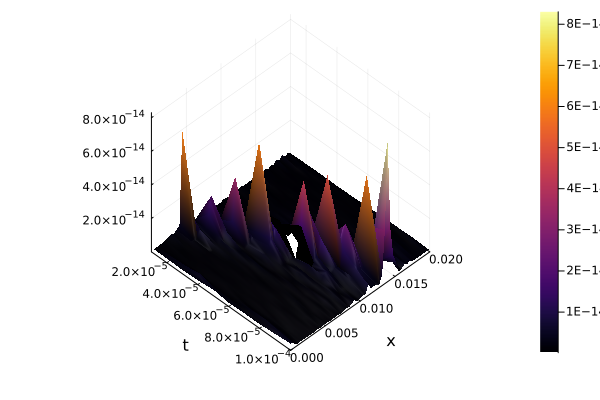

In [260]:
w = [1]
N = 200;
m = 2;

funt = (x,t) -> SpecialFunction(w, x, t, m, N);
Solu = (x,t) -> -exp(-x^2/(4*t))*sqrt(pi)*(2*t-x^2)/(4*t^(5/2));

L = 0.02
Nt = 10;
Nx = 101;
T = 0.0001
tt = T/(Nt):T/(Nt):T
xx = 0:2*L/(Nx-1):L

Qsol = Complex.(zeros(length(xx),length(tt)))
Rsol = Complex.(zeros(length(xx),length(tt)))
for i2 = 1:Nt
    Qsol[:,i2] = map(x->funt(x,tt[i2]),xx)
    Rsol[:,i2] = map(x->Solu(x,tt[i2]),xx)
end
surface(tt,xx, abs.((Qsol-Rsol)./Rsol) .+ 1e-16,camera = (45, 45), xlabel = "t", ylabel = "x")|>display


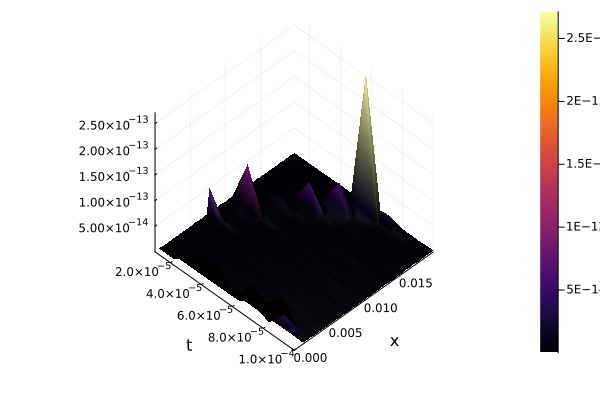

In [261]:
w = [1]
N = 200;
m = 3;

funt = (x,t) -> SpecialFunction(w, x, t, m, N);
Solu = (x,t) -> -exp(-x^2/(4*t))*sqrt(pi)*x*(-6*t+x^2)/(8*t^(7/2));

L = 0.02
Nt = 10;
Nx = 100;
T = 0.0001
tt = T/(Nt):T/(Nt):T
xx = 0:2*L/(Nx-1):L

Qsol = Complex.(zeros(length(xx),length(tt)))
Rsol = Complex.(zeros(length(xx),length(tt)))
for i2 = 1:Nt
    Qsol[:,i2] = map(x->funt(x,tt[i2]),xx)
    Rsol[:,i2] = map(x->Solu(x,tt[i2]),xx)
end
surface(tt,xx, abs.((Qsol-Rsol)./Rsol) .+ 1e-16,camera = (45, 45), xlabel = "t", ylabel = "x")|>display


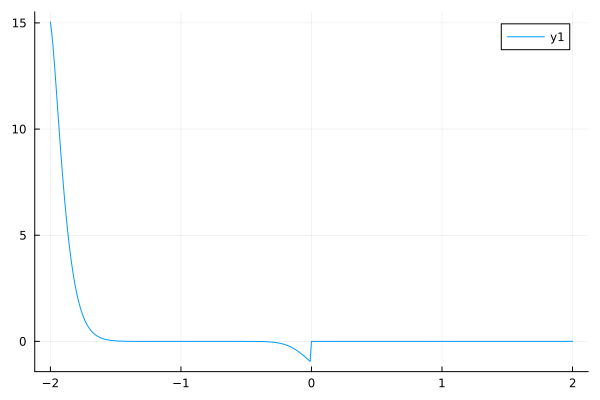

401-element Vector{Float64}:
 15.043355887700422
 14.550807368459225
 13.895387094829069
 13.131006808366186
 12.300160717500253
 11.435961578442104
 10.563849442619118
  9.703020826507302
  8.867621071759665
  8.067735716946483
  7.310213041932436
  6.599342914119414
  5.937415228686665
  ⋮
 -6.117472938748617e-55
 -7.137051761873386e-56
 -5.0978941156238473e-57
 -7.965459555662261e-57
  3.8871442631631836e-56
 -4.699621137840734e-57
 -3.1861838222649046e-58
  2.5091197600336123e-57
 -2.01625695002701e-58
  2.7132346611474578e-58
 -3.982729777831131e-59
 -2.800356875037514e-60

In [262]:
using SpecialFunctions
include("..\\Code_jail\\Cheb.jl")
x = -2:.01:2
w = [1]
N = 200;
m = -1;
t = 0.01
funt = x -> SpecialFunction(w, x, t, m, N);
plot(x,real.(funt.(x))/(2*pi)+erfc.(x ./ (2*sqrt(t)))/2)|>display
real.(funt.(x))/(2*pi)+erfc.(x ./ (2*sqrt(t)))/2|>display

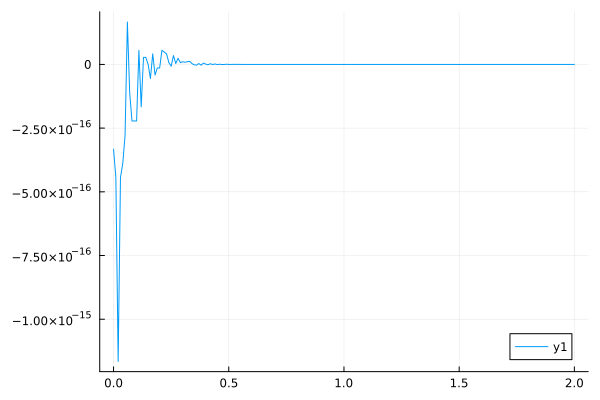

In [263]:
using SpecialFunctions
include("..\\Code_jail\\Cheb.jl")
x = 0:.01:2
w = [1]
N = 200;
m = -1;
t = 0.01
funt = x -> SpecialFunction(w, x, t, m, N);
plot(x,real.(funt.(x))/(2*pi)+erfc.(x ./ (2*sqrt(t)))/2)